<a href="https://colab.research.google.com/github/cryptorider86/VWAP-Scalp/blob/main/grid_system_bot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1. KEEP this cell. It installs the necessary libraries for the backtesting strategy.
!pip install numpy ccxt backtesting seaborn matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.2/132.2 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 68.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.1/192.1 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.0/644.0 kB 39.0 MB/s eta 0:00:00


In [2]:
# 2. KEEP this cell. Определение параметров стратегии и загрузки данных.

# --- Параметры загрузки данных ---
symbol = 'API3/USDT' # Торговая пара
timeframe = '5m' # Таймфрейм
limit_per_request = 25 # Количество свечей за один запрос при пагинации
days_back = 60 # Количество дней назад, с которых начинаем загрузку данных (для пагинации вперед)
# Примечание: Фактическое количество загруженных данных может быть ограничено биржей.


# --- Параметры стратегии ---
#mysize = 50 # Размер позиции (например, количество контрактов или лотов)
grid_distance = 0.005 # Расстояние между уровнями сетки
# slatr = 1.5 * grid_distance # Стоп-лосс на основе grid_distance (рассчитывается в стратегии)
# TPSLRatio = 0.5 # Отношение тейк-профита к стоп-лоссу (рассчитывается в стратегии)

# Параметры стоп-лосса и тейк-профита на основе ATR (используются в ячейке 3)
#ATR_SL_Multiplier = 3.0 # Множитель ATR для стоп-лосса
#ATR_TP_Multiplier = 1.5 # Множитель ATR для тейк-профита (изменен с 0.5 на 0.75 для примера)

# Параметры расчета ATR (используются в ячейке 3)
atr_span = 16 # Период для расчета ATR (используется в ячейке 2)


# --- Параметры Backtest ---
initial_cash = 1000 # Начальный капитал для бэктеста (увеличено для примера)
margin_rate = 1/10 # Маржинальное требование (например, 1:20 плечо) (изменено с 1/100)
hedging_enabled = True # Включить хеджирование (возможность одновременно иметь длинные и короткие позиции)
exclusive_orders_enabled = False # Разрешить несколько ордеров одновременно

In [3]:
# 3. KEEP this cell. This cell fetches real-time data from MEXC
import numpy as np
import pandas as pd
import ccxt
# import pandas_ta as ta # Not using pandas_ta for ATR
from google.colab import userdata
from backtesting import Strategy, Backtest
import backtesting
import datetime
import time # Import time for rate limiting

try:
    # Fetch real-time data from MEXC
    exchange = ccxt.mexc({
        'enableRateLimit': True, # Enable rate limiting
    }) # No API keys needed for public data

    # Use parameters from the parameters cell
    # symbol = 'API3/USDT' # Moved to parameters cell
    # timeframe = '5m' # Moved to parameters cell
    # limit_per_request = 25 # Moved to parameters cell
    # days_back = 60 # Moved to parameters cell

    all_ohlcv = []

    # Use days_back parameter for the start date
    since = exchange.parse8601((datetime.datetime.now() - datetime.timedelta(days=days_back)).isoformat())

    # --- Изменена логика цикла для запроса вперед ---
    # Запрашиваем данные, двигаясь вперед от 'since'
    while True:
        try:
            # Fetch OHLCV data using parameters
            ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since=since, limit=limit_per_request)

            if not ohlcv:
                # No more data available or reached current time
                print("No more historical data available or reached current time.")
                break

            # Append new data to the list (since we are going forward)
            all_ohlcv.extend(ohlcv)

            # Update 'since' to the timestamp of the last fetched bar + 1ms
            # This will be the starting point for the next request (going further forward in time)
            since = ohlcv[-1][0] + 1

            # print(f"Fetched {len(ohlcv)} bars, total fetched: {len(all_ohlcv)}") # Reduced chattiness


            # Optional: Add a small delay to avoid hitting rate limits, even with enableRateLimit
            # time.sleep(exchange.rateLimit / 1000)

            # Optional: Add a condition to stop fetching after a certain number of bars
            # if len(all_ohlcv) >= total_bars_to_fetch: # Пример условия остановки
            #    print(f"Reached target number of bars ({total_bars_to_fetch}). Stopping.")
            #    break


        except Exception as e:
            print(f"An error occurred during data fetching: {e}")
            break # Stop fetching on error

    # Convert to DataFrame
    dataF = pd.DataFrame(all_ohlcv, columns=['timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'])

    # Convert timestamp to datetime and set as index
    dataF['timestamp'] = pd.to_datetime(dataF['timestamp'], unit='ms')
    dataF.set_index('timestamp', inplace=True)

    # --- Добавлена проверка на минимальное количество данных ---
    min_data_required = 20 # Минимальное количество свечей, необходимое для расчетов и бэктестинга
    print(f"Загружено {len(dataF)} свечей.")
    display(dataF.head())

    if len(dataF) < min_data_required:
        print(f"Недостаточно данных для продолжения расчетов и бэктестинга. Загружено только {len(dataF)} свечей, требуется минимум {min_data_required}.")
        dfpl = None # Устанавливаем dfpl в None, чтобы предотвратить ошибки в следующих ячейках
    else:
        # --- Остальная часть кода по обработке данных и сигналам ---
        # grid_distance = 0.005 # Moved to parameters cell
        midprice = dataF['Close'].iloc[-1] # Use the last close price as midprice

        def generate_grid(midprice, grid_distance, grid_range):
            return (np.arange(midprice-grid_range, midprice+grid_range, grid_distance))

        grid = generate_grid(midprice=midprice, grid_distance=grid_distance, grid_range=0.1) # grid_range is hardcoded here, could also be a parameter

        signal = [0]*len(dataF)
        # Adjust loop to iterate through the potentially larger dataF
        for index, row in dataF.iterrows():
            for p in grid:
                if min(row.Low, row.High)<p and max(row.Low, row.High)>p:
                    signal[dataF.index.get_loc(index)]=1 # Use index location
            # No need for manual counter i+=1, pandas iterrows is sufficient

        dataF["signal"]=signal

        dfpl = dataF[:].copy()
        def SIGNAL():
            return dfpl.signal

        # Manual ATR Calculation using atr_span parameter
        high_low = dfpl['High'] - dfpl['Low']
        high_close = np.abs(dfpl['High'] - dfpl['Close'].shift())
        low_close = np.abs(dfpl['Low'] - dfpl['Close'].shift())
        ranges = pd.concat([high_low, high_close, low_close], axis=1)
        true_range = np.max(ranges, axis=1)
        dfpl['ATR'] = true_range.ewm(span=atr_span, adjust=False).mean() # Using atr_span from parameters


        dfpl.dropna(inplace=True)

        display(dfpl.head())


except Exception as e:
    print(f"Произошла ошибка: {e}")
    dataF = None
    dfpl = None # Also set dfpl to None in case of error

/usr/local/lib/python3.11/dist-packages/backtesting/_plotting.py:55: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support, such as old IDEs. Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


No more historical data available or reached current time.
Загружено 17280 свечей.


Open    High     Low   Close   Volume
timestamp                                                   
2025-06-10 10:45:00  0.7563  0.7577  0.7552  0.7577  1414.24
2025-06-10 10:50:00  0.7577  0.7588  0.7573  0.7587  6247.29
2025-06-10 10:55:00  0.7587  0.7589  0.7583  0.7588  1347.00
2025-06-10 11:00:00  0.7588  0.7595  0.7576  0.7584  2988.04
2025-06-10 11:05:00  0.7584  0.7587  0.7548  0.7555  4952.52

Open    High     Low   Close   Volume  signal       ATR
timestamp                                                                     
2025-06-10 10:45:00  0.7563  0.7577  0.7552  0.7577  1414.24       0  0.002500
2025-06-10 10:50:00  0.7577  0.7588  0.7573  0.7587  6247.29       1  0.002382
2025-06-10 10:55:00  0.7587  0.7589  0.7583  0.7588  1347.00       1  0.002173
2025-06-10 11:00:00  0.7588  0.7595  0.7576  0.7584  2988.04       1  0.002141
2025-06-10 11:05:00  0.7584  0.7587  0.7548  0.7555  4952.52       1  0.002348

In [ ]:
# Стратегия торговли.
class MyStrat(Strategy):
    # Add ATR multipliers as parameters
    ATR_SL_Multiplier = 3.0
    ATR_TP_Multiplier = 1.5
    # Добавляем параметр для желаемой долларовой суммы на сделку
    dollar_amount_per_trade = 100 # Например, 100 долларов на сделку

    # Добавляем параметры для размера позиции как процент от капитала
    equity_percentage_per_trade = 0.1 # Например, 10% от капитала за сделку (в долях)

    # Добавляем параметр для выбора метода определения размера позиции
    # Возможные значения: 'dollar' или 'percentage'
    position_sizing_mode = 'percentage' # По умолчанию используем доллары


    def init(self):
        super().init()
        self.signal1 = self.I(SIGNAL)
        # Make ATR multipliers accessible within the strategy
        # self.atr_sl_mult = self.I(lambda: self.ATR_SL_Multiplier, name='ATR_SL_Multiplier') # Больше не нужно как отдельный индикатор
        # self.atr_tp_mult = self.I(lambda: self.ATR_TP_Multiplier, name='ATR_TP_Multiplier') # Больше не нужно как отдельный индикатор


    def next(self):
        super().next()
        # slatr = 1.5 * grid_distance  # Используем переменную grid_distance - this was based on grid_distance, not ATR. We will use the ATR based logic below.
        # TPSLRatio = 0.5 # This was used with the grid_distance based SL/TP, not with ATR based.

        # Ensure we have enough data to calculate ATR before proceeding
        if len(self.data.ATR) == 0:
            return

        # Рассчитываем размер позиции в зависимости от выбранного режима
        current_price = self.data.Close[-1]
        mysize = 0 # Инициализируем mysize

        if current_price > 0: # Избегаем деления на ноль
            if self.position_sizing_mode == 'dollar':
                # Размер в единицах на основе долларовой суммы
                mysize = round(self.dollar_amount_per_trade / current_price) # Округляем до ближайшего целого числа
            elif self.position_sizing_mode == 'percentage':
                # Размер в единицах на основе процента от текущего капитала
                current_equity = self.equity # Получаем текущий капитал
                if current_equity > 0:
                    # Рассчитываем количество единиц, которое соответствует желаемому проценту капитала
                    # Учитываем маржу
                    # mysize = (current_equity * self.equity_percentage_per_trade) / (current_price * self.margin_rate) # Это может быть не совсем корректно в зависимости от настроек backtesting.py
                    # Более простой подход: рассчитать стоимость позиции и разделить на цену
                    position_value = current_equity * self.equity_percentage_per_trade
                    mysize = round(position_value / current_price) # Округляем до ближайшего целого числа

        if self.signal1 == 1 and len(self.trades) <= 10000 and mysize > 0: # Добавляем проверку mysize > 0
            # Для сигналов покупки и продажи, используем стоп-лосс и тейк-профит
            # на основе ATR
            # Access the current ATR value and the multiplier parameters
            current_atr = self.data.ATR[-1]
            sl_mult = self.ATR_SL_Multiplier # Используем напрямую атрибут класса
            tp_mult = self.ATR_TP_Multiplier # Используем напрямую атрибут класса


            # Ensure ATR and multipliers are valid before calculating SL/TP
            if pd.notna(current_atr) and pd.notna(sl_mult) and pd.notna(tp_mult):

                # Buy signal: Set SL below current close, TP above current close
                sl_buy = current_price - current_atr * sl_mult
                tp_buy = current_price + current_atr * tp_mult
                self.buy(sl=sl_buy, tp=tp_buy, size=mysize) # Используем рассчитанный mysize

                # Sell signal: Set SL above current close, TP below current close
                sl_sell = current_price + current_atr * sl_mult
                tp_sell = current_price - current_atr * tp_mult
                self.sell(sl=sl_sell, tp=tp_sell, size=mysize) # Используем рассчитанный mysize


# --- Параметры для Backtest ---
# Make sure dfpl is not None before creating Backtest instance
if dfpl is not None:
    bt = Backtest(dfpl, MyStrat, cash=initial_cash, margin=margin_rate, hedging=hedging_enabled, exclusive_orders=exclusive_orders_enabled)

    # --- Запуск Backtest ---
    stat = bt.run()

    # --- Вывод статистики ---
    display(stat) # Use display for better formatting in Colab
else:
    print("Бэктест не может быть запущен из-за недостатка данных.")

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/tmp/ipython-input-3569464165.py:82: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  stat = bt.run()


Start                     2025-06-10 07:45:00
End                       2025-08-09 07:40:00
Duration                     59 days 23:55:00
Exposure Time [%]                    61.06481
Equity Final [$]                   1118.31568
Equity Peak [$]                    1149.79879
Return [%]                           11.83157
Buy & Hold Return [%]                 1.14104
Return (Ann.) [%]                   105.78994
Volatility (Ann.) [%]                48.27575
CAGR [%]                             97.44704
Sharpe Ratio                          2.19137
Sortino Ratio                        10.88486
Calmar Ratio                         14.92276
Alpha [%]                            11.85199
Beta                                 -0.01789
Max. Drawdown [%]                    -7.08917
Avg. Drawdown [%]                    -0.55204
Max. Drawdown Duration       33 days 23:50:00
Avg. Drawdown Duration        0 days 13:01:00
# Trades                                10606
Win Rate [%]                         66.73581
Best Trade [%]                        3.20851
Worst Trade [%]                      -4.70901
Avg. Trade [%]                        0.00622
Max. Trade Duration           0 days 18:40:00
Avg. Trade Duration           0 days 00:57:00
Profit Factor                         1.02575
Expectancy [%]                         0.0115
SQN                                   1.10752
Kelly Criterion                         0.016
_strategy                             MyStrat
_equity_curve                             ...
_trades                          Size  Ent...
dtype: object

In [ ]:
# 5. KEEP this cell. It displays the details of the trades from the backtest.
stat._trades.sort_values(by="EntryBar").head(20)

Size  EntryBar  ExitBar  EntryPrice  ExitPrice        SL        TP  \
0    -50         4        6      0.7348   0.729355  0.745690  0.729355   
15    50         4       27      0.7348   0.723910  0.723910  0.740245   
1    -50         5       12      0.7316   0.726143  0.742515  0.726143   
23    50         5       28      0.7316   0.720685  0.720685  0.737057   
2    -50         6       12      0.7300   0.724461  0.741078  0.724461   
31    50         6       43      0.7300   0.718922  0.718922  0.735539   
3    -50        10       12      0.7292   0.724643  0.738315  0.724643   
6     50        10       19      0.7292   0.733757  0.720085  0.733757   
4     50        13       14      0.7252   0.730355  0.714890  0.730355   
26   -50        13       30      0.7252   0.720045  0.735510  0.720045   
5     50        14       16      0.7279   0.733154  0.717391  0.733154   
24   -50        14       28      0.7279   0.722646  0.738409  0.722646   
7     50        15       19      0.7298   0.734948  0.719504  0.734948   
16   -50        15       27      0.7298   0.724652  0.740096  0.724652   
8     50        16       19      0.7295   0.734448  0.719603  0.734448   
17   -50        16       27      0.7295   0.724552  0.739397  0.724552   
22    50        17       28      0.7317   0.720638  0.720638  0.737231   
13   -50        17       26      0.7317   0.726169  0.742762  0.726169   
9    -50        18       22      0.7327   0.726885  0.744331  0.726885   
21    50        18       28      0.7327   0.721069  0.721069  0.738515   

         PnL  Commission  ReturnPct           EntryTime            ExitTime  \
0   0.272249         0.0   0.007410 2025-07-30 07:30:00 2025-07-30 07:40:00   
15 -0.544497         0.0  -0.014820 2025-07-30 07:30:00 2025-07-30 09:25:00   
1   0.272866         0.0   0.007459 2025-07-30 07:35:00 2025-07-30 08:10:00   
23 -0.545733         0.0  -0.014919 2025-07-30 07:35:00 2025-07-30 09:30:00   
2   0.276941         0.0   0.007587 2025-07-30 07:40:00 2025-07-30 08:10:00   
31 -0.553882         0.0  -0.015175 2025-07-30 07:40:00 2025-07-30 10:45:00   
3   0.227870         0.0   0.006250 2025-07-30 08:00:00 2025-07-30 08:10:00   
6   0.227870         0.0   0.006250 2025-07-30 08:00:00 2025-07-30 08:45:00   
4   0.257753         0.0   0.007108 2025-07-30 08:15:00 2025-07-30 08:20:00   
26  0.257753         0.0   0.007108 2025-07-30 08:15:00 2025-07-30 09:40:00   
5   0.262723         0.0   0.007219 2025-07-30 08:20:00 2025-07-30 08:30:00   
24  0.262723         0.0   0.007219 2025-07-30 08:20:00 2025-07-30 09:30:00   
7   0.257403         0.0   0.007054 2025-07-30 08:25:00 2025-07-30 08:45:00   
16  0.257403         0.0   0.007054 2025-07-30 08:25:00 2025-07-30 09:25:00   
8   0.247414         0.0   0.006783 2025-07-30 08:30:00 2025-07-30 08:45:00   
17  0.247414         0.0   0.006783 2025-07-30 08:30:00 2025-07-30 09:25:00   
22 -0.553084         0.0  -0.015118 2025-07-30 08:35:00 2025-07-30 09:30:00   
13  0.276542         0.0   0.007559 2025-07-30 08:35:00 2025-07-30 09:20:00   
9   0.290772         0.0   0.007937 2025-07-30 08:40:00 2025-07-30 09:00:00   
21 -0.581545         0.0  -0.015874 2025-07-30 08:40:00 2025-07-30 09:30:00   

          Duration   Tag  Entry_SIGNAL  Exit_SIGNAL  
0  0 days 00:10:00  None             1            0  
15 0 days 01:55:00  None             1            0  
1  0 days 00:35:00  None             1            1  
23 0 days 01:55:00  None             1            1  
2  0 days 00:30:00  None             0            1  
31 0 days 03:05:00  None             0            0  
3  0 days 00:10:00  None             0            1  
6  0 days 00:45:00  None             0            1  
4  0 days 00:05:00  None             1            1  
26 0 days 01:25:00  None             1            0  
5  0 days 00:10:00  None             1            1  
24 0 days 01:10:00  None             1            1  
7  0 days 00:20:00  None             1            1  
16 0 days 01:00:00  None         

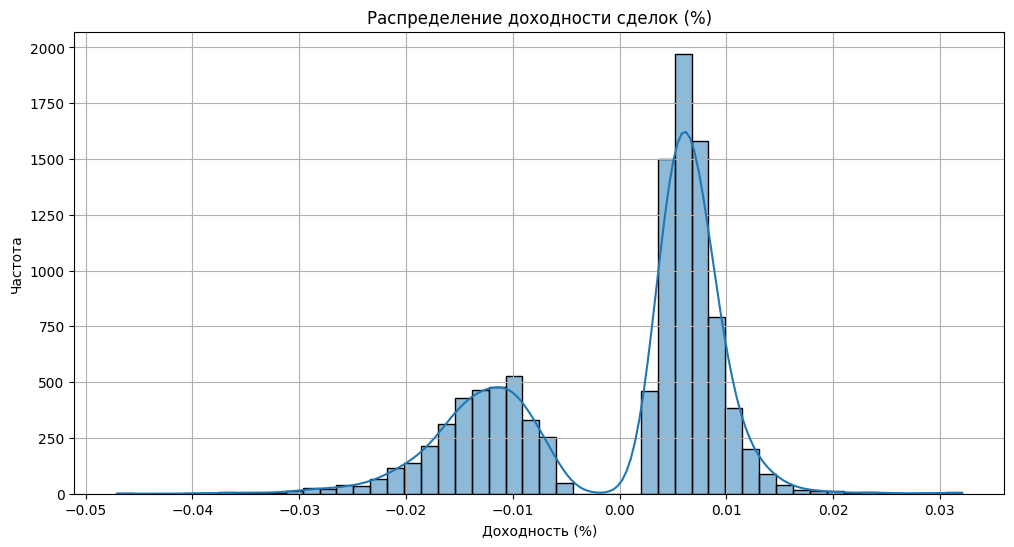

In [ ]:
# Визуализация распределения доходности сделок с использованием Seaborn

import seaborn as sns
import matplotlib.pyplot as plt

# Получаем данные доходности сделок из статистики бэктеста
trade_returns = stat._trades['ReturnPct']

# Создаем фигуру и оси для графика
plt.figure(figsize=(12, 6))

# Строим гистограмму распределения доходности
sns.histplot(trade_returns, kde=True, bins=50) # kde=True добавляет оценку плотности ядра

# Настраиваем график
plt.title('Распределение доходности сделок (%)')
plt.xlabel('Доходность (%)')
plt.ylabel('Частота')
plt.grid(True)

# Отображаем график
plt.show()

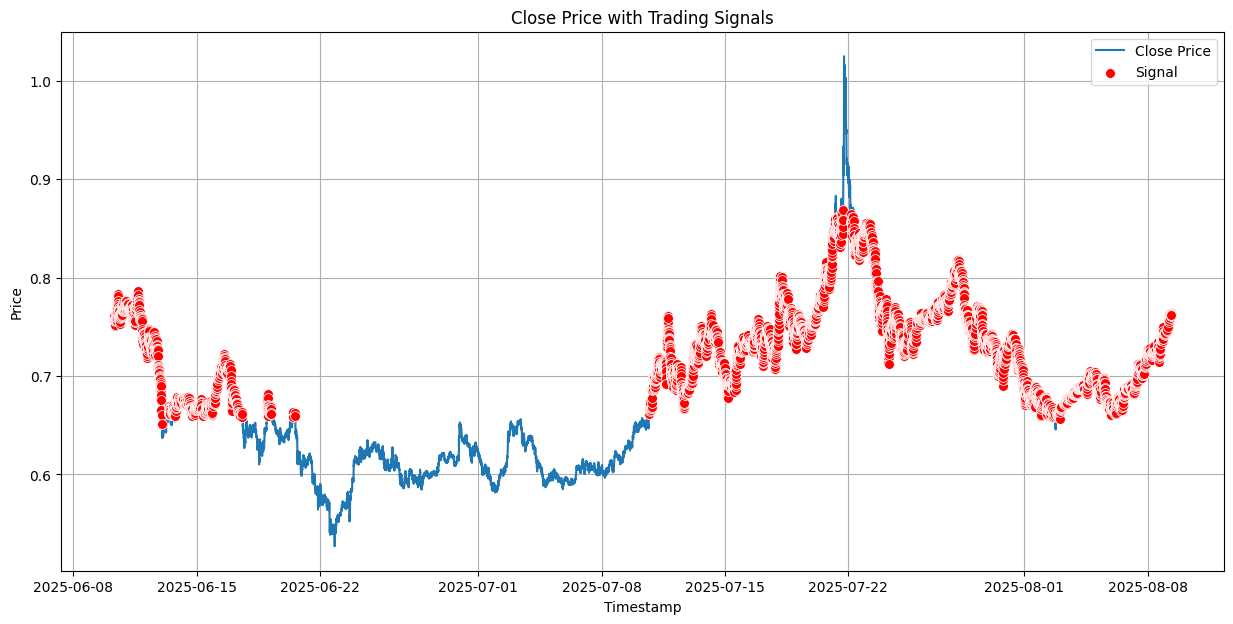

In [ ]:
# Установим seaborn, если он еще не установлен (обычно уже есть в Colab)
import seaborn as sns
import matplotlib.pyplot as plt

# Создадим фигуру и оси для графика
plt.figure(figsize=(15, 7))
ax1 = plt.gca()

# Построим график цены закрытия
sns.lineplot(data=dfpl['Close'], ax=ax1, label='Close Price')

# Наложим точки, где сигнал равен 1
# Используем только те точки, где сигнал активен
signal_points = dfpl[dfpl['signal'] == 1]
sns.scatterplot(data=signal_points['Close'], ax=ax1, color='red', label='Signal', s=50, zorder=5) # zorder=5 для отображения поверх линии

# Настроим график
ax1.set_title('Close Price with Trading Signals')
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Price')
ax1.legend()
plt.grid(True)

# Отобразим график
plt.show()

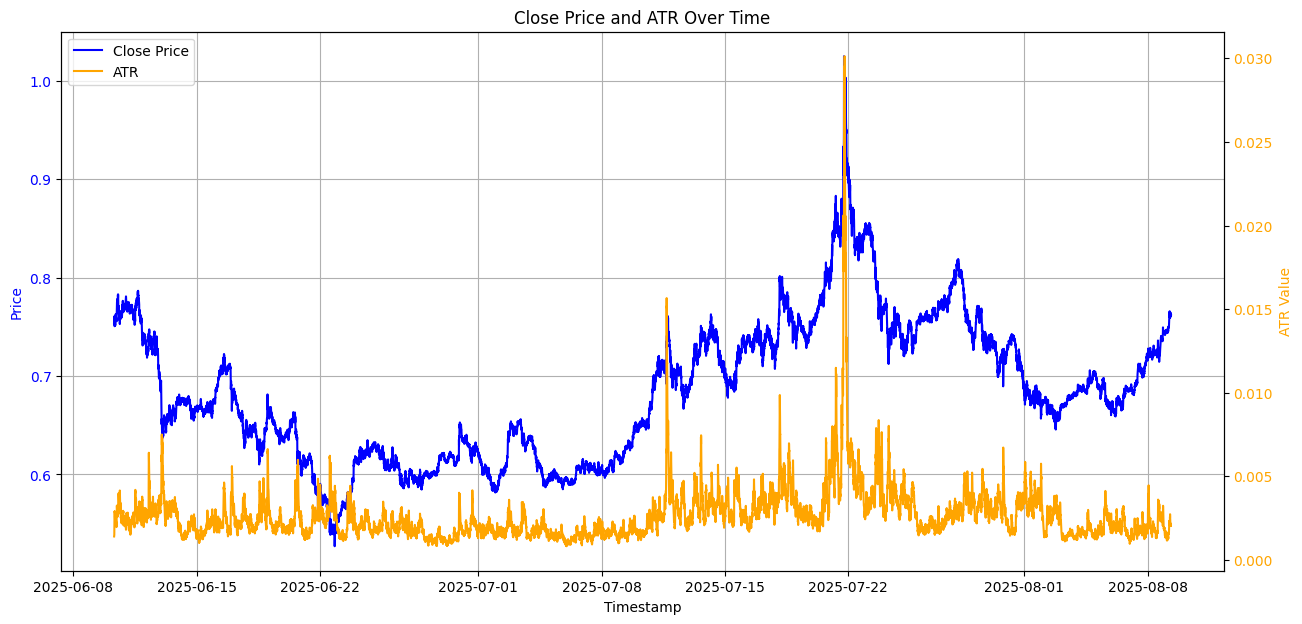

In [ ]:
# Визуализация цены закрытия и индикатора ATR с использованием Matplotlib

import matplotlib.pyplot as plt

# Создаем фигуру и оси для графика. Используем две оси Y для разных масштабов
fig, ax1 = plt.subplots(figsize=(15, 7))
ax2 = ax1.twinx() # Создаем вторую ось Y, которая делит ту же ось X

# Построим график цены закрытия на первой оси Y
ax1.plot(dfpl.index, dfpl['Close'], color='blue', label='Close Price')
ax1.set_ylabel('Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Построим график ATR на второй оси Y
ax2.plot(dfpl.index, dfpl['ATR'], color='orange', label='ATR')
ax2.set_ylabel('ATR Value', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Настраиваем общие элементы графика
ax1.set_title('Close Price and ATR Over Time')
ax1.set_xlabel('Timestamp')
ax1.grid(True)

# Добавляем легенды с обеих осей
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')


# Отобразим график
plt.show()

In [ ]:
import numpy as np

# Define the parameter grid for optimization
params_grid = {
    'ATR_SL_Multiplier': np.arange(0.5, 6.0, 0.25),  # Test multipliers from 1.0 to 3.0 with step 0.5
    'ATR_TP_Multiplier': np.arange(0.5, 9.0, 0.25)  # Test multipliers from 0.5 to 2.0 with step 0.25
}

print("Parameter grid defined:")
display(params_grid)

Parameter grid defined:


{'ATR_SL_Multiplier': array([0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 , 2.75, 3.  ,
        3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  , 5.25, 5.5 , 5.75]),
 'ATR_TP_Multiplier': array([0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 , 2.75, 3.  ,
        3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  , 5.25, 5.5 , 5.75,
        6.  , 6.25, 6.5 , 6.75, 7.  , 7.25, 7.5 , 7.75, 8.  , 8.25, 8.5 ,
        8.75])}

In [ ]:
if dfpl is None:
    print("Data is not loaded or insufficient. Cannot proceed with optimization.")
else:
    # Check if bt object exists and is not None, if not, re-initialize it
    try:
        bt
        if bt is None:
             print("Backtest object is None. Re-initializing Backtest object.")
             bt = Backtest(dfpl, MyStrat, cash=initial_cash, margin=margin_rate, hedging=hedging_enabled, exclusive_orders=exclusive_orders_enabled)
    except NameError:
         print("Backtest object not found. Initializing Backtest object.")
         bt = Backtest(dfpl, MyStrat, cash=initial_cash, margin=margin_rate, hedging=hedging_enabled, exclusive_orders=exclusive_orders_enabled)

    # Convert numpy arrays in params_grid to lists
    params_grid_list = {k: v.tolist() for k, v in params_grid.items()}


    # Run the optimization
    optimized_stats = bt.optimize(
        **params_grid_list, # Use the converted dictionary
        maximize='Equity Final [$]'
    )

    # Display the optimization results
    display(optimized_stats)

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1624: UserWarning: Searching for best of 748 configurations.
  output = _optimize_grid()


Backtest.optimize:   0%|          | 0/748 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1637: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  for stats in (bt.run(**params)


Backtest.run:   0%|          | 0/17279 [00:00<?, ?bar/s]

/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1545: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  stats = self.run(**dict(zip(heatmap.index.names, best_params)))


Start                     2025-06-10 07:45:00
End                       2025-08-09 07:40:00
Duration                     59 days 23:55:00
Exposure Time [%]                    63.78472
Equity Final [$]                   1382.26435
Equity Peak [$]                    1589.05187
Return [%]                           38.22643
Buy & Hold Return [%]                 1.14104
Return (Ann.) [%]                   483.41263
Volatility (Ann.) [%]               359.34361
CAGR [%]                            616.65817
Sharpe Ratio                          1.34527
Sortino Ratio                        15.97362
Calmar Ratio                          27.7357
Alpha [%]                            38.28568
Beta                                 -0.05193
Max. Drawdown [%]                   -17.42926
Avg. Drawdown [%]                    -1.91205
Max. Drawdown Duration       19 days 00:35:00
Avg. Drawdown Duration        0 days 14:15:00
# Trades                                10614
Win Rate [%]                          8.63953
Best Trade [%]                       11.25458
Worst Trade [%]                      -1.60426
Avg. Trade [%]                        0.02677
Max. Trade Duration           3 days 11:00:00
Avg. Trade Duration           0 days 01:25:00
Profit Factor                         1.11271
Expectancy [%]                        0.03506
SQN                                   2.12166
Kelly Criterion                        0.0068
_strategy                 MyStrat(ATR_SL_M...
_equity_curve                             ...
_trades                          Size  Ent...
dtype: object

In [ ]:
import backtesting
from bokeh.plotting import show, output_notebook # Import show and output_notebook
backtesting.set_bokeh_output(notebook=True) # Change to notebook=True

# Check if bt object exists and is not None
if 'bt' in locals() and bt is not None:
    # Check if stat object exists and is not None
    if 'stat' in locals() and stat is not None:
        # Call plot and then explicitly show the plot using the stat object from the optimized run
        plot = bt.plot(
            results=stat, # Pass the stat object from the optimized run
            show_legend=False,
            plot_width=None,
            plot_equity=True,
            plot_return=False,
            plot_pl=False,
            plot_volume=False,
            plot_drawdown=False,
            smooth_equity=False,
            relative_equity=True,
            superimpose=True,
            resample=False,
            reverse_indicators=False,
            open_browser=False # Set open_browser=False for notebook environment
        )
        # show(plot) # Explicitly show the plot # Removed this line
    else:
        print("Backtest statistics ('stat' object) not found or is None. Please run the backtest with optimized parameters first.")
else:
    print("Backtest object ('bt') not found or is None. Cannot plot results.")